### All needed impots

In [1]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 5.5MB 21.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=fd90791746ee8ca6eeda864c057ac2d2884bc07bfb154b91603518d835741f69
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


### Downlodaing Ethereum dataframe with yahoo finance API and then plotting the dataframe

**reset_index** method is used only to make normal numerical indexes, instead of *Date* beeig an index


In [2]:
df = yf.download('ETH-USD', start='2015-08-07')
df = df.reset_index()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100
...,...,...,...,...,...,...,...
1996,2021-01-27,1358.333374,1368.074097,1215.311279,1253.187134,1253.187134,39394416990
1997,2021-01-28,1251.279785,1321.613037,1226.173950,1298.101807,1298.101807,39790481941
1998,2021-01-29,1369.086792,1428.981201,1292.240112,1382.522827,1382.522827,53611955259
1999,2021-01-30,1382.231934,1402.399780,1328.529053,1376.115479,1376.115479,30616574234


Text(0, 0.5, 'Close Price (USD)')

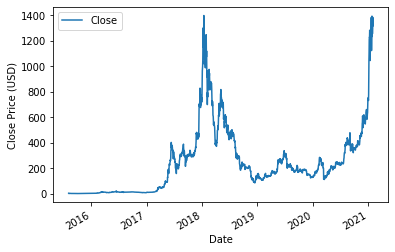

In [3]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [7]:
df.Close.values.shape

(2001,)

In [6]:
df.Close.values.reshape(-1,1).shape

(2001, 1)

### Normalization

Since the scaler expects the data to be shaped as (x, y), I'm adding a dummy dimension using reshape before applying it. 

**reshape** method transforms array of *Closed* values from shape (2001, 1) into (2001, 1)

In [8]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape, np.isnan(scaled_close).any()

((2001, 1), False)

### Preprocessing

 LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is: **[batch_size, sequence_length, n_features]**

 The process of building sequences works by creating a sequence of a specified length at position 0. Then it's shifted one position to the right (e.g. 1) and creates another sequence. The process is repeated until all possible positions are used.

 Here, *SEQ_LEN* parameter is set to 20, which means, that 20 days are predicting the next one

In [9]:
SEQ_LEN = 20

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len + 1):
        d.append(data[index: index + seq_len])


    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

X_train.shape, X_test.shape

((1882, 20, 1), (100, 20, 1))

Simply checking arrays

In [10]:
print(df['Close'].tail(5))

print(scaled_close[-5:])

1996    1253.187134
1997    1298.101807
1998    1382.522827
1999    1376.115479
2000    1316.006836
Name: Close, dtype: float64
[[0.89739654]
 [0.92957072]
 [0.99004487]
 [0.98545503]
 [0.94239681]]


In [ ]:
X_test[99], X_test.shape

(array([[0.7471424 ],
        [0.80968232],
        [0.8725151 ],
        [0.83912047],
        [0.88332079],
        [0.88091005],
        [0.9003281 ],
        [0.98630061],
        [0.98986666],
        [0.80311459],
        [0.88545163],
        [0.88149628],
        [0.99655393],
        [0.94841976],
        [0.97180347],
        [0.89739654],
        [0.92957072],
        [0.99004487],
        [0.98545503],
        [0.94324195]]), (100, 20, 1))

In [ ]:
y_test[-5:], y_test.shape

(array([[0.89739654],
        [0.92957072],
        [0.99004487],
        [0.98545503],
        [0.94324195]]), (100, 1))

### Model

Bidirectional RNNs allows us to train on the sequence data in forward and backward (reversed) direction. In practice, this approach works well with LSTMs.
CuDNNLSTM is a “Fast LSTM implementation backed by cuDNN”. 

The output layer has a single neuron (predicted Ethereum price). 

In [11]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN 

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

"""model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))"""

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

### Training

In [12]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 40)            3680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 80)            26240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 80)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                16320     
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

In [13]:
BATCH_SIZE = 32
EPOCHS = 100

history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
53/53 [==============================] - 20s 115ms/step - loss: 0.0075 - val_loss: 0.0129
Epoch 2/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 3/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0078 - val_loss: 0.0102
Epoch 4/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 5/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 7/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 9/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 10/100
53/53 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.00

In [14]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 6s 2s/step - loss: 0.0016


0.0015593771822750568

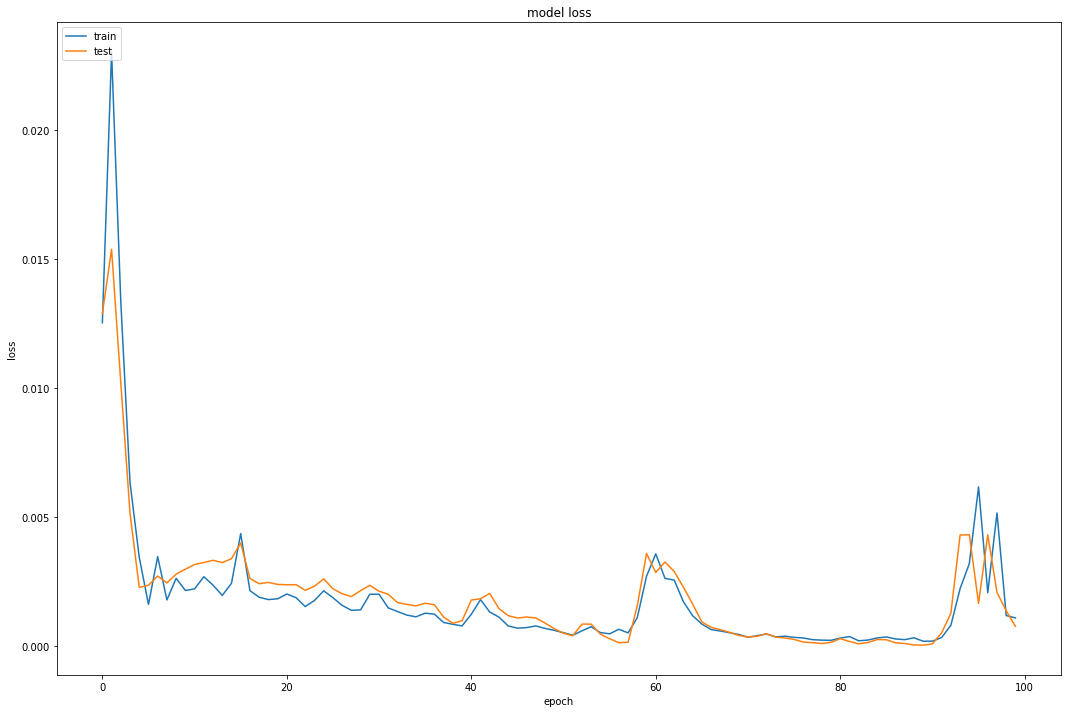

In [15]:
plt.figure(figsize = (18,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prediction

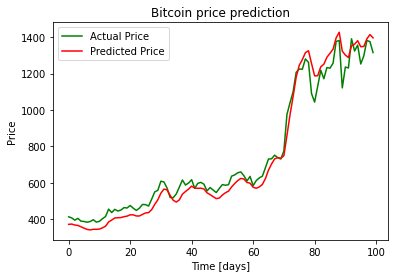

<Figure size 1296x864 with 0 Axes>

In [17]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.figure(figsize = (18,12))
plt.show();

Checking some real (*y_test_inverse*) and predicted *y_hat_inverse* values

In [18]:
y_test_inverse[85:]

array([[1230.17224121],
       [1257.27954102],
       [1377.29589844],
       [1382.27404785],
       [1121.57092285],
       [1236.51220703],
       [1230.99060059],
       [1391.609375  ],
       [1324.41479492],
       [1357.05810547],
       [1253.18713379],
       [1298.10180664],
       [1382.52282715],
       [1376.11547852],
       [1316.00683594]])

In [19]:
y_hat_inverse[85:]

array([[1312.0829],
       [1334.6174],
       [1397.0269],
       [1427.7587],
       [1323.8783],
       [1302.102 ],
       [1288.7804],
       [1353.1338],
       [1361.7306],
       [1381.0868],
       [1348.2439],
       [1349.4612],
       [1391.446 ],
       [1414.9175],
       [1397.0576]], dtype=float32)

In [21]:
df.tail(15)

,Date,Open,High,Low,Close,Adj Close,Volume
1986,2021-01-17,1233.453369,1265.644653,1174.388550,1230.172241,1230.172241,29258032819
1987,2021-01-18,1230.313232,1259.450073,1187.311035,1257.279541,1257.279541,25817455560
1988,2021-01-19,1257.434570,1432.300049,1254.522949,1377.295898,1377.295898,47195935190
1989,2021-01-20,1375.248413,1405.744141,1243.299927,1382.274048,1382.274048,46784030909
1990,2021-01-21,1382.684448,1382.684448,1098.476196,1121.570923,1121.570923,45932464754
1991,2021-01-22,1118.889038,1271.687622,1046.596558,1236.512207,1236.512207,43918338506
1992,2021-01-23,1235.267944,1272.151123,1200.893311,1230.990601,1230.990601,27253895441
1993,2021-01-24,1231.210571,1395.111328,1225.274048,1391.609375,1391.609375,36418163554
1994,2021-01-25,1390.639893,1467.784912,1304.973999,1324.414795,1324.414795,43565777745
1995,2021-01-26,1323.741699,1376.085083,1253.340332,1357.058105,1357.058105,41572917750


#### Now, let's predict into the future.

I'm making a new sequence, where the last value will be repeated twice (inserting a dummy data) : twice  [0.94239681] and [0.94239681]] at the *predicted_array[100]*

In [22]:
def get_prediction_array(X_test):
  a = np.insert(X_test,[100],X_test[99], axis=0)
  for i_ in range(len(a[100]) - 1):
    if(i_ == 20):
      a[100][i_][0] == a[100][i_ - 1][0]
    else:
      a[100][i_][0] = a[100][i_ + 1][0]
  
  return a

In [23]:
pred_array = get_prediction_array(X_test)
pred_array.shape

(101, 20, 1)

In [24]:
print(pred_array[98], '\n') 
print(pred_array[99], '\n')
print(pred_array[100], '\n')

[[0.78060322]
 [0.7471424 ]
 [0.80968232]
 [0.8725151 ]
 [0.83912047]
 [0.88332079]
 [0.88091005]
 [0.9003281 ]
 [0.98630061]
 [0.98986666]
 [0.80311459]
 [0.88545163]
 [0.88149628]
 [0.99655393]
 [0.94841976]
 [0.97180347]
 [0.89739654]
 [0.92957072]
 [0.99004487]
 [0.98545503]] 

[[0.7471424 ]
 [0.80968232]
 [0.8725151 ]
 [0.83912047]
 [0.88332079]
 [0.88091005]
 [0.9003281 ]
 [0.98630061]
 [0.98986666]
 [0.80311459]
 [0.88545163]
 [0.88149628]
 [0.99655393]
 [0.94841976]
 [0.97180347]
 [0.89739654]
 [0.92957072]
 [0.99004487]
 [0.98545503]
 [0.94239681]] 

[[0.80968232]
 [0.8725151 ]
 [0.83912047]
 [0.88332079]
 [0.88091005]
 [0.9003281 ]
 [0.98630061]
 [0.98986666]
 [0.80311459]
 [0.88545163]
 [0.88149628]
 [0.99655393]
 [0.94841976]
 [0.97180347]
 [0.89739654]
 [0.92957072]
 [0.99004487]
 [0.98545503]
 [0.94239681]
 [0.94239681]] 



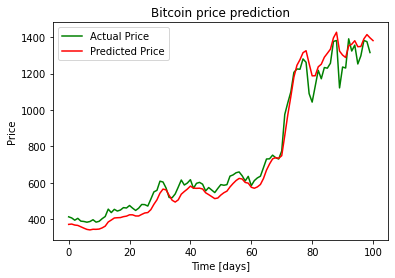

In [25]:
y_hat = model.predict(pred_array)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [26]:
y_hat_inverse[-1] #predicted pEthereum rice for the next day

array([1381.7424], dtype=float32)

In [ ]:
#Saving the model

file_name = 'LSTM_ETH-1f.h5'
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_ETH-1f.h5` to disk
